In [1]:
%matplotlib inline
from snorkel import SnorkelSession
from tcre.env import *
from tcre import supervision
from tcre.supervision import SPLIT_DEV, SPLIT_TRAIN, SPLIT_VAL, SPLIT_TEST, SPLIT_MAP
from tcre import labeling
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from IPython.display import display
session = SnorkelSession()
classes = supervision.get_candidate_classes()

In [2]:
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-sgm', 'run1')
output_dir

'/lab/data/results/modeling-sgm/run1'

### Splits

TODO: Consider downsampling and hyperparameter optimization for SGM model; for now, just train on all available data

### Generative Model Training

In [11]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in classes:
    print(f'Running generative model training for relation class {c}')
    candidate_class = classes[c]
    ds = DependencySelector()
    X = labeling.get_labels_matrix(session, candidate_class, SPLIT_TRAIN)
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True, seed=TCRE_SEED)
    gen_model.train(X, deps=deps, decay=0.95, step_size=0.1/X.shape[0], reg_param=0.0)
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for relation class InducingCytokine
Inferred cardinality: 2
Running generative model training for relation class SecretedCytokine
Inferred cardinality: 2
Running generative model training for relation class InducingTranscriptionFactor
Inferred cardinality: 2


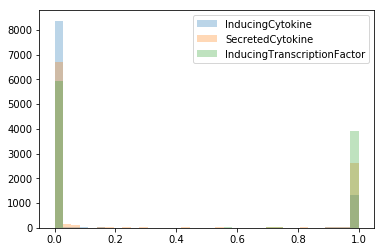

In [12]:
%matplotlib inline
for c in res_train:
    plt.hist(res_train[c][2], bins=36, label=c, alpha=.3)
    plt.legend()

In [13]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 30000 marginals


In [14]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine                10000
inducing_transcription_factor    10000
secreted_cytokine                10000
dtype: int64

In [15]:
def display_statistics(split, candidate_class):
    print('{} (split = {} [{}]):'.format(candidate_class.name, split, SPLIT_MAP[split]))
    X = labeling.get_labels_matrix(session, candidate_class, split)
    y = supervision.get_gold_labels(session, candidate_class, split)
    model = res_train[candidate_class.name][0]
    model.error_analysis(session, X, y.values)
    df = X.lf_stats(session, y.values, model.learned_lf_stats()['Accuracy'])
    display(df.style.background_gradient(subset=['Empirical Acc.', 'Learned Acc.']))
    return df

In [16]:
res_stats = collections.defaultdict(lambda: {})
for split in [SPLIT_VAL, SPLIT_TEST]:
    for c in classes:
        candidate_class = classes[c]
        res_stats[c][split] = display_statistics(split, candidate_class)

InducingCytokine (split = 3 [val]):
Scores (Un-adjusted)
Pos. class accuracy: 0.739
Neg. class accuracy: 0.878
Precision            0.354
Recall               0.739
F1                   0.479
----------------------------------------
TP: 17 | FP: 31 | TN: 224 | FN: 6



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.0107914,0.0107914,0.00719424,1,0,0,2,1,0.269231
LF_indck_comp_neg_sec,1,0.133094,0.133094,0.129496,0,0,1,36,0.972973,0.676633
LF_indck_comp_xor,2,0.158273,0.158273,0.154676,4,3,0,37,0.931818,0.704342
LF_indck_dsup_imexpresso_mp04,3,0.230216,0.230216,0.223022,7,12,0,45,0.8125,0.663228
LF_indck_dsup_imexpresso_mp08,4,0.158273,0.158273,0.147482,3,8,0,33,0.818182,0.651713
LF_indck_dsup_imexpresso_mp12,5,0.129496,0.129496,0.118705,3,6,0,27,0.833333,0.580882
LF_indck_dsup_imexpresso_mp20,6,0.104317,0.104317,0.0971223,3,6,1,19,0.758621,0.527629
LF_indck_heur_closer_ck_to_ct,7,0.208633,0.208633,0.165468,0,0,3,55,0.948276,0.803698
LF_indck_heur_closer_ct_to_ck,8,0.172662,0.172662,0.147482,0,0,1,47,0.979167,0.748876
LF_indck_heur_closer_ref,9,0.294964,0.294964,0.248201,0,0,4,78,0.95122,0.838002


SecretedCytokine (split = 3 [val]):
Scores (Un-adjusted)
Pos. class accuracy: 0.796
Neg. class accuracy: 0.78
Precision            0.443
Recall               0.796
F1                   0.569
----------------------------------------
TP: 39 | FP: 49 | TN: 174 | FN: 10



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.0294118,0.0294118,0.0294118,3,3,0,2,0.625,0.225
LF_secck_comp_neg_ind,1,0.0257353,0.0257353,0.0257353,0,0,0,7,1,0.257669
LF_secck_comp_xor,2,0.202206,0.202206,0.202206,24,25,0,6,0.545455,0.687973
LF_secck_dsup_imexpresso_mp04,3,0.279412,0.279412,0.275735,16,28,1,31,0.618421,0.578977
LF_secck_dsup_imexpresso_mp08,4,0.158088,0.158088,0.158088,10,23,0,10,0.465116,0.492063
LF_secck_dsup_imexpresso_mp12,5,0.139706,0.139706,0.139706,7,22,0,9,0.421053,0.485163
LF_secck_dsup_imexpresso_mp20,6,0.106618,0.106618,0.106618,7,13,0,9,0.551724,0.486268
LF_secck_heur_closer_ck_to_ct,7,0.253676,0.253676,0.224265,0,0,10,59,0.855072,0.791267
LF_secck_heur_closer_ct_to_ck,8,0.213235,0.213235,0.191176,0,0,3,55,0.948276,0.717726
LF_secck_heur_closer_ref,9,0.360294,0.360294,0.327206,0,0,13,85,0.867347,0.830271


InducingTranscriptionFactor (split = 3 [val]):
Scores (Un-adjusted)
Pos. class accuracy: 0.841
Neg. class accuracy: 0.724
Precision            0.425
Recall               0.841
F1                   0.565
----------------------------------------
TP: 37 | FP: 50 | TN: 131 | FN: 7



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.773333,0.773333,0.742222,1,3,24,146,0.844828,0.808724
LF_indtf_heur_closer_ct_to_tf,1,0.2,0.2,0.182222,0,0,3,42,0.933333,0.743263
LF_indtf_heur_closer_ref,2,0.28,0.28,0.253333,0,0,7,56,0.888889,0.769892
LF_indtf_heur_closer_tf_to_ct,3,0.133333,0.133333,0.12,0,0,4,26,0.866667,0.691525
LF_indtf_heur_complex_cand_01,4,0.88,0.88,0.848889,0,0,37,161,0.813131,0.722349
LF_indtf_heur_complex_cand_02,5,0.515556,0.515556,0.484444,0,0,17,99,0.853448,0.781595
LF_indtf_heur_distref,6,0.195556,0.195556,0.164444,0,0,1,43,0.977273,0.765036
LF_indtf_heur_distref_10,7,1,1,0.968889,33,71,11,110,0.635556,0.83997
LF_indtf_heur_distref_15,8,1,1,0.968889,36,108,8,73,0.484444,0.727091
LF_indtf_heur_distref_20,9,1,1,0.968889,40,122,4,59,0.44,0.650005


InducingCytokine (split = 2 [test]):
Scores (Un-adjusted)
Pos. class accuracy: 0.69
Neg. class accuracy: 0.889
Precision            0.345
Recall               0.69
F1                   0.46
----------------------------------------
TP: 20 | FP: 38 | TN: 304 | FN: 9



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.0242588,0.0242588,0.0242588,0,1,1,7,0.777778,0.125
LF_indck_comp_neg_sec,1,0.140162,0.140162,0.140162,0,0,2,50,0.961538,0.663752
LF_indck_comp_xor,2,0.175202,0.175202,0.175202,8,5,2,50,0.892308,0.698882
LF_indck_dsup_imexpresso_mp04,3,0.247978,0.247978,0.239892,8,14,1,69,0.836957,0.669921
LF_indck_dsup_imexpresso_mp08,4,0.191375,0.191375,0.169811,2,8,1,60,0.873239,0.65264
LF_indck_dsup_imexpresso_mp12,5,0.16442,0.16442,0.145553,2,7,1,51,0.868852,0.588542
LF_indck_dsup_imexpresso_mp20,6,0.118598,0.118598,0.107817,2,7,3,32,0.772727,0.569177
LF_indck_heur_closer_ck_to_ct,7,0.234501,0.234501,0.177898,0,0,3,84,0.965517,0.809131
LF_indck_heur_closer_ct_to_ck,8,0.204852,0.204852,0.15903,0,0,1,75,0.986842,0.74871
LF_indck_heur_closer_ref,9,0.328841,0.328841,0.264151,0,0,3,119,0.97541,0.844015


SecretedCytokine (split = 2 [test]):
Scores (Un-adjusted)
Pos. class accuracy: 0.891
Neg. class accuracy: 0.843
Precision            0.548
Recall               0.891
F1                   0.679
----------------------------------------
TP: 57 | FP: 47 | TN: 253 | FN: 7



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.0137363,0.0137363,0.0137363,4,1,0,0,0.8,0.369231
LF_secck_comp_neg_ind,1,0.032967,0.032967,0.032967,0,0,0,12,1,0.379747
LF_secck_comp_xor,2,0.181319,0.181319,0.181319,34,20,0,12,0.69697,0.669923
LF_secck_dsup_imexpresso_mp04,3,0.241758,0.241758,0.236264,21,33,0,34,0.625,0.568761
LF_secck_dsup_imexpresso_mp08,4,0.104396,0.104396,0.104396,11,19,0,8,0.5,0.507903
LF_secck_dsup_imexpresso_mp12,5,0.0934066,0.0934066,0.0934066,8,18,0,8,0.470588,0.501553
LF_secck_dsup_imexpresso_mp20,6,0.0934066,0.0934066,0.0906593,7,19,0,8,0.441176,0.50096
LF_secck_heur_closer_ck_to_ct,7,0.252747,0.252747,0.208791,0,0,5,87,0.945652,0.786673
LF_secck_heur_closer_ct_to_ck,8,0.181319,0.181319,0.156593,0,0,3,63,0.954545,0.745797
LF_secck_heur_closer_ref,9,0.337912,0.337912,0.291209,0,0,8,115,0.934959,0.829495


InducingTranscriptionFactor (split = 2 [test]):
Scores (Un-adjusted)
Pos. class accuracy: 0.741
Neg. class accuracy: 0.64
Precision            0.331
Recall               0.741
F1                   0.457
----------------------------------------
TP: 43 | FP: 87 | TN: 155 | FN: 15



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.796667,0.796667,0.77,7,3,31,198,0.857741,0.806997
LF_indtf_heur_closer_ct_to_tf,1,0.136667,0.136667,0.123333,0,0,4,37,0.902439,0.704527
LF_indtf_heur_closer_ref,2,0.236667,0.236667,0.22,0,0,8,63,0.887324,0.767345
LF_indtf_heur_closer_tf_to_ct,3,0.14,0.14,0.126667,0,0,4,38,0.904762,0.656716
LF_indtf_heur_complex_cand_01,4,0.853333,0.853333,0.826667,0,0,49,207,0.808594,0.732154
LF_indtf_heur_complex_cand_02,5,0.516667,0.516667,0.49,0,0,27,128,0.825806,0.780164
LF_indtf_heur_distref,6,0.18,0.18,0.153333,0,0,4,50,0.925926,0.753515
LF_indtf_heur_distref_10,7,1,1,0.973333,37,110,21,132,0.563333,0.84691
LF_indtf_heur_distref_15,8,1,1,0.973333,44,151,14,91,0.45,0.721139
LF_indtf_heur_distref_20,9,1,1,0.973333,50,178,8,64,0.38,0.636542
